# Index   

### Importing libraries

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import  applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPool2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')
import random
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import glob
import shutil
import os
import itertools
from sklearn.metrics import confusion_matrix ,classification_report

In [4]:
# import pandas as pd 
import os
import pathlib
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [5]:

import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE" 



ModuleNotFoundError: No module named 'tensorflow_hub'

# Building the neuronal network

https://medium.com/@himancodes/building-an-image-classifier-from-scratch-using-convolutional-neural-networks-c9ebcde3a53e

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(3, activation='softmax')) #last layer should have as many neuron as options = 3 sports

In [ ]:
Folder structure

|--image-classification (folder)
|--|--dataset (folder)
|--|--|--train (folder)
|--|--|--|--cowbell (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--|--tulip (folder)
|--|--|--|--|--image_1.jpg
|--|--|--|--|--image_2.jpg
|--|--|--|--|--...
|--|--|--test (folder)
|--|--|--|--image_1.jpg
|--|--|--|--image_2.jpg
|--|--output (folder)
|--|--|--data.h5
|--|--|--labels.h5
|--|--global.py
|--|--train_test.py

To implement f1 macro score in Keras should be done in one of the following solutions:

In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# https://www.kaggle.com/code/guglielmocamporese/macro-f1-score-keras

In [ ]:
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
    def  on_train_begin(self,logs={}):
      self.f1_macro=[]
    def on_epoch_end(self, epoch, logs=None):
      y_pred=self.model.predict(x_test).round()
      y_true=y_test
      score=f1_score(y_true, y_pred, average='macro')
      self.f1_macro.append(score)
      print(" F1 macro :",score)

metrics=MetricsCallback()

model.fit(x_train, y_train,validation_data=(x_test,y_test),batch_size=batch_size, epochs=5,callbacks=[metrics])

# https://colab.research.google.com/drive/1hTf0LjO-h2l6diVkvj0gQme25clUdFt2#scrollTo=S3hxXkGocmUq
# https://androidkt.com/calculate-f1-macro-in-keras/

# multiclass f1 macro score https://towardsdatascience.com/f-beta-score-in-keras-part-ii-15f91f07c9a4


In [ ]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [ ]:
# Instantiate custom callback and create 2 callbacks to control learning rate and early stop

epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [ ]:
#Train the model
'''Note unlike how you are told it is BETTER to make the base model trainable from the outset
It will converge faster and have a lower validation losss'''

history=model.fit(x=train_gen, 
                     epochs=epochs, 
                     verbose=1, 
                     callbacks=callbacks,  
                     validation_data=valid_gen,
                    validation_steps=None,  
                    shuffle=False,  
                    initial_epoch=0
                    )

In [ ]:
def tr_plot(tr_data, start_epoch):
    

    
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [ ]:
def predictor(test_gen, test_steps):
    '''Define a function which takes in a test generator and an integer test_steps
    and generates predictions on the test set including a confusion matrix
    and a classification report'''
    
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    


In [ ]:
#Save the model
  
subject='bengali digits' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

## 2a Manera

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_path = '../input/sports-classification/train'
valid_path = '../input/sports-classification/valid'
test_path = '../input/sports-classification/test'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import  applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPool2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
import random
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import glob
import shutil
import os
import itertools
from sklearn.metrics import confusion_matrix ,classification_report
# import numpy as np 
# import pandas as pd 
import os
import pathlib
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE" 
from tensorflow.keras import layers
Transfer Learning
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size= (224,224),batch_size=10,shuffle=False)
Found 13572 images belonging to 100 classes.
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size= (224,224),batch_size=10,shuffle=False)
Found 500 images belonging to 100 classes.
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))

mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.1))
mobilenet_model.add(Dense(100, activation='softmax'))
2022-02-16 09:07:50.363094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.476936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.477632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.478711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 09:07:50.479574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.480230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:50.480874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.268808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.269632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.270260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 09:07:52.270857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
9412608/9406464 [==============================] - 0s 0us/step
9420800/9406464 [==============================] - 0s 0us/step
mobilenet_model.summary()
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
=================================================================
Total params: 2,677,412
Trainable params: 419,428
Non-trainable params: 2,257,984
_________________________________________________________________
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
results=mobilenet_model.fit(train_batches,epochs=10)  
2022-02-16 09:07:54.446711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/10
2022-02-16 09:07:57.726453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
1358/1358 [==============================] - 100s 67ms/step - loss: 3.8587 - accuracy: 0.1648
Epoch 2/10
1358/1358 [==============================] - 39s 28ms/step - loss: 1.8174 - accuracy: 0.5371
Epoch 3/10
1358/1358 [==============================] - 38s 28ms/step - loss: 1.1337 - accuracy: 0.6905
Epoch 4/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.8724 - accuracy: 0.7543
Epoch 5/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.6977 - accuracy: 0.7996
Epoch 6/10
1358/1358 [==============================] - 38s 28ms/step - loss: 0.5712 - accuracy: 0.8296
Epoch 7/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.4902 - accuracy: 0.8528
Epoch 8/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.4212 - accuracy: 0.8748
Epoch 9/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.3493 - accuracy: 0.8974
Epoch 10/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.3070 - accuracy: 0.9119
mobilenet_model.evaluate(test_batches)
50/50 [==============================] - 4s 69ms/step - loss: 0.2401 - accuracy: 0.9220
[0.24005533754825592, 0.921999990940094]

In [ ]:
mobilenet_model.summary()
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
=================================================================
Total params: 2,677,412
Trainable params: 419,428
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
results=mobilenet_model.fit(train_batches,epochs=10)  


2022-02-16 09:07:54.446711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/10
2022-02-16 09:07:57.726453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
1358/1358 [==============================] - 100s 67ms/step - loss: 3.8587 - accuracy: 0.1648
Epoch 2/10
1358/1358 [==============================] - 39s 28ms/step - loss: 1.8174 - accuracy: 0.5371
Epoch 3/10
1358/1358 [==============================] - 38s 28ms/step - loss: 1.1337 - accuracy: 0.6905
Epoch 4/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.8724 - accuracy: 0.7543
Epoch 5/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.6977 - accuracy: 0.7996
Epoch 6/10
1358/1358 [==============================] - 38s 28ms/step - loss: 0.5712 - accuracy: 0.8296
Epoch 7/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.4902 - accuracy: 0.8528
Epoch 8/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.4212 - accuracy: 0.8748
Epoch 9/10
1358/1358 [==============================] - 39s 28ms/step - loss: 0.3493 - accuracy: 0.8974
Epoch 10/10
1358/1358 [==============================] - 39s 29ms/step - loss: 0.3070 - accuracy: 0.9119
mobilenet_model.evaluate(test_batches)
50/50 [==============================] - 4s 69ms/step - loss: 0.2401 - accuracy: 0.9220
[0.24005533754825592, 0.921999990940094]

Following tutorials of https://www.tensorflow.org/tutorials/load_data/images to generate convolutional 

In [65]:
data_dir= pathlib.Path(r"C:\Users\march\000 Treball Ju`yter 000\Hackathons\Image_sports_classification\Imágenes-data-science-ii\train")
image_count = len(list(data_dir.glob('*/*.jpg')))
batch_size = 32
img_height = 180
img_width = 180

In [66]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 210 files belonging to 3 classes.
Using 168 files for training.


In [67]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 210 files belonging to 3 classes.
Using 42 files for validation.


In [68]:
class_names = train_ds.class_names
print(class_names)

['baseball', 'cricket', 'football']


In [69]:
train_ds.take(1)


<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

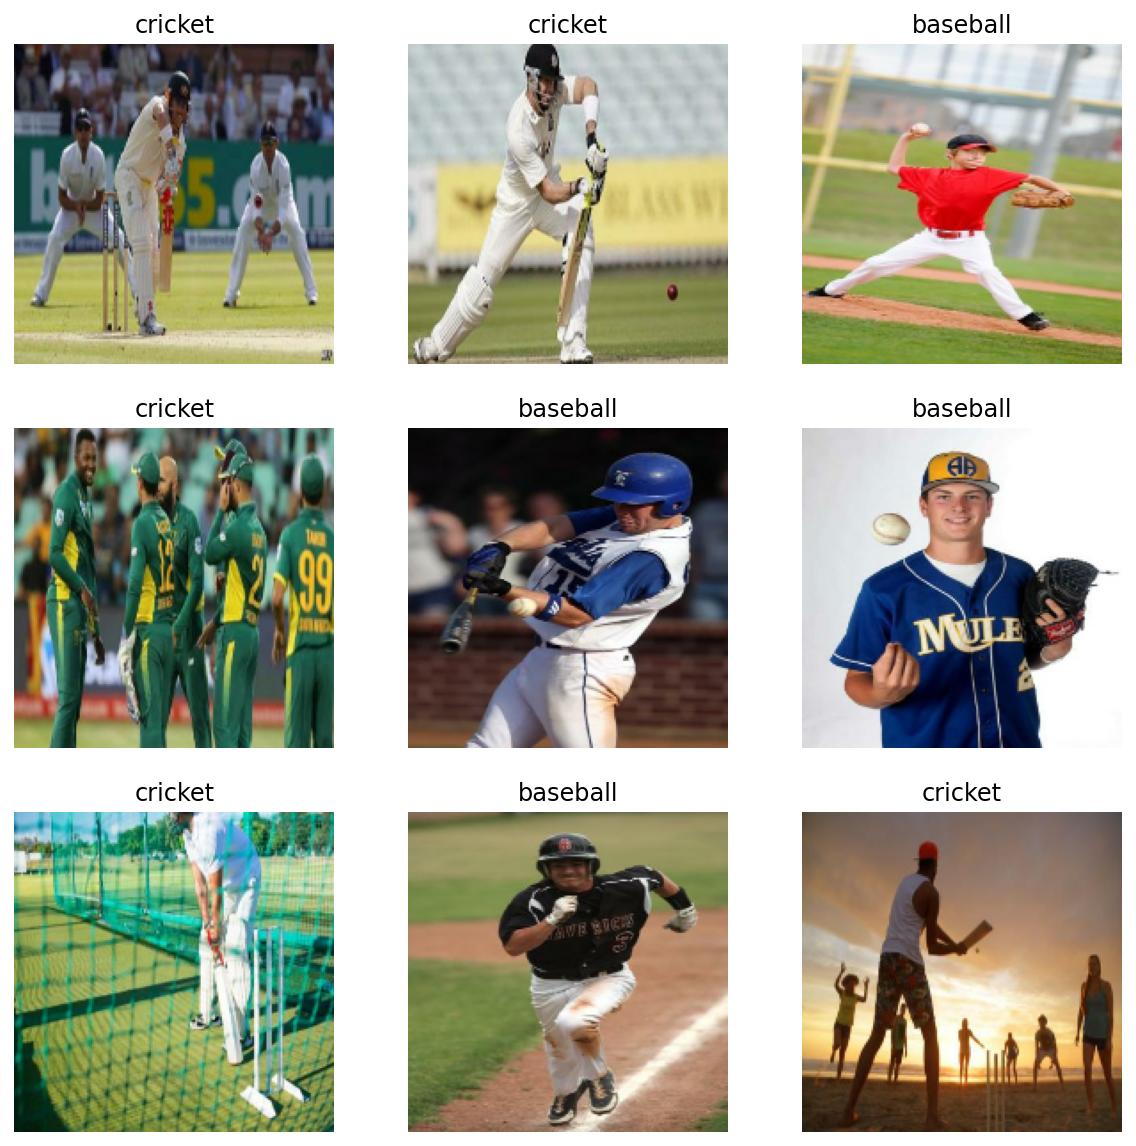

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [71]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [72]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [74]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [75]:
epochs=5

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
6/6 [==============================] - 8s 1s/step - loss: 1.1068 - accuracy: 0.3036 - val_loss: 1.1341 - val_accuracy: 0.2619
Epoch 2/5
6/6 [==============================] - 7s 1s/step - loss: 1.0970 - accuracy: 0.3155 - val_loss: 1.1094 - val_accuracy: 0.2619
Epoch 3/5
6/6 [==============================] - 7s 1s/step - loss: 1.0830 - accuracy: 0.3393 - val_loss: 1.1559 - val_accuracy: 0.2619
Epoch 4/5
6/6 [==============================] - 7s 1s/step - loss: 1.0578 - accuracy: 0.3929 - val_loss: 1.1524 - val_accuracy: 0.2857
Epoch 5/5
6/6 [==============================] - 8s 1s/step - loss: 0.9816 - accuracy: 0.5179 - val_loss: 1.2190 - val_accuracy: 0.3571


In [53]:
import seaborn as sns
sns.set_style('white')

In [76]:
def plot_accur_loss (history, epochs=3):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8,8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

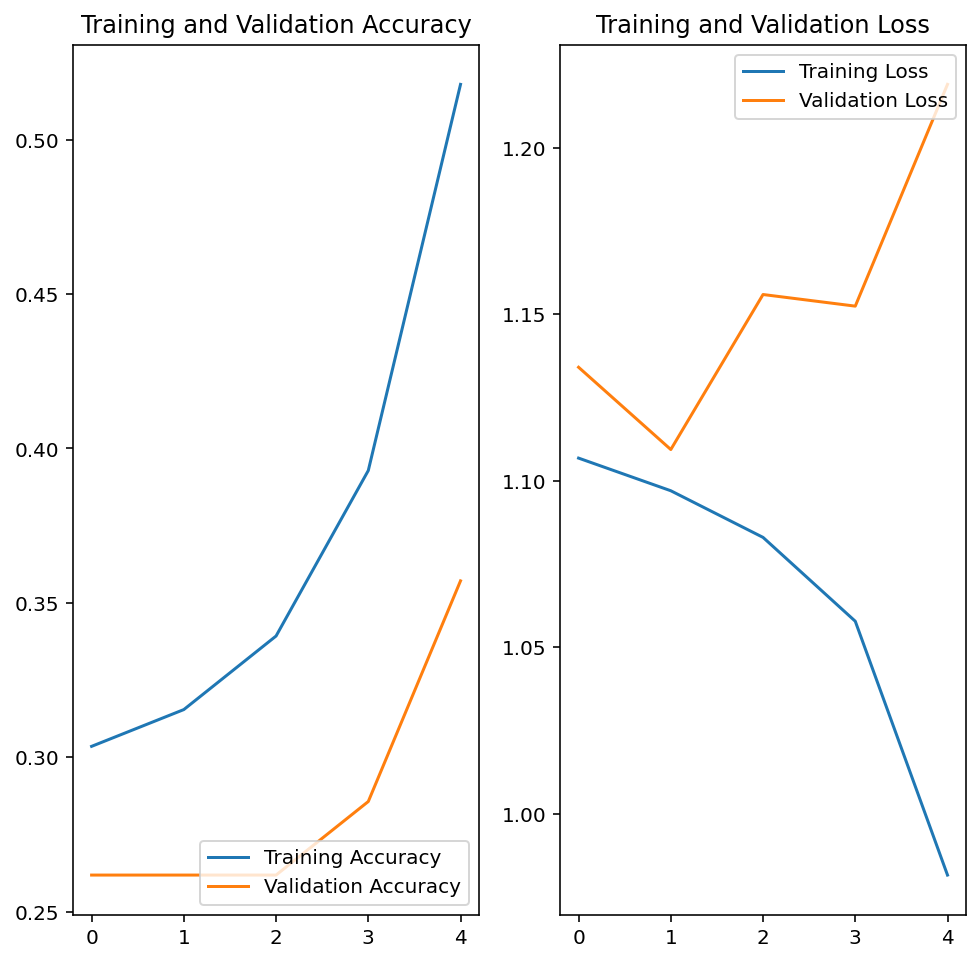

In [77]:
plot_accur_loss (history, epochs)

In [78]:
img_height = 180
img_width = 180




data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [79]:
num_classes = 3

model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [80]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
epochs = 15
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
6/6 [==============================] - 9s 1s/step - loss: 1.8182 - accuracy: 0.4167 - val_loss: 1.0908 - val_accuracy: 0.2857
Epoch 2/15
6/6 [==============================] - 7s 1s/step - loss: 1.1768 - accuracy: 0.3512 - val_loss: 1.0907 - val_accuracy: 0.2619
Epoch 3/15
6/6 [==============================] - 6s 1s/step - loss: 1.0991 - accuracy: 0.3155 - val_loss: 1.1178 - val_accuracy: 0.2619
Epoch 4/15
6/6 [==============================] - 6s 1s/step - loss: 1.0938 - accuracy: 0.3274 - val_loss: 1.0955 - val_accuracy: 0.2857
Epoch 5/15
6/6 [==============================] - 6s 980ms/step - loss: 1.0800 - accuracy: 0.3988 - val_loss: 1.0668 - val_accuracy: 0.4524
Epoch 6/15
6/6 [==============================] - 7s 1s/step - loss: 1.0692 - accuracy: 0.3571 - val_loss: 1.0534 - val_accuracy: 0.4762
Epoch 7/15
6/6 [==============================] - 7s 1s/step - loss: 1.0218 - accuracy: 0.5060 - val_loss: 1.0079 - val_accuracy: 0.5714
Epoch 8/15
6/6 [======================

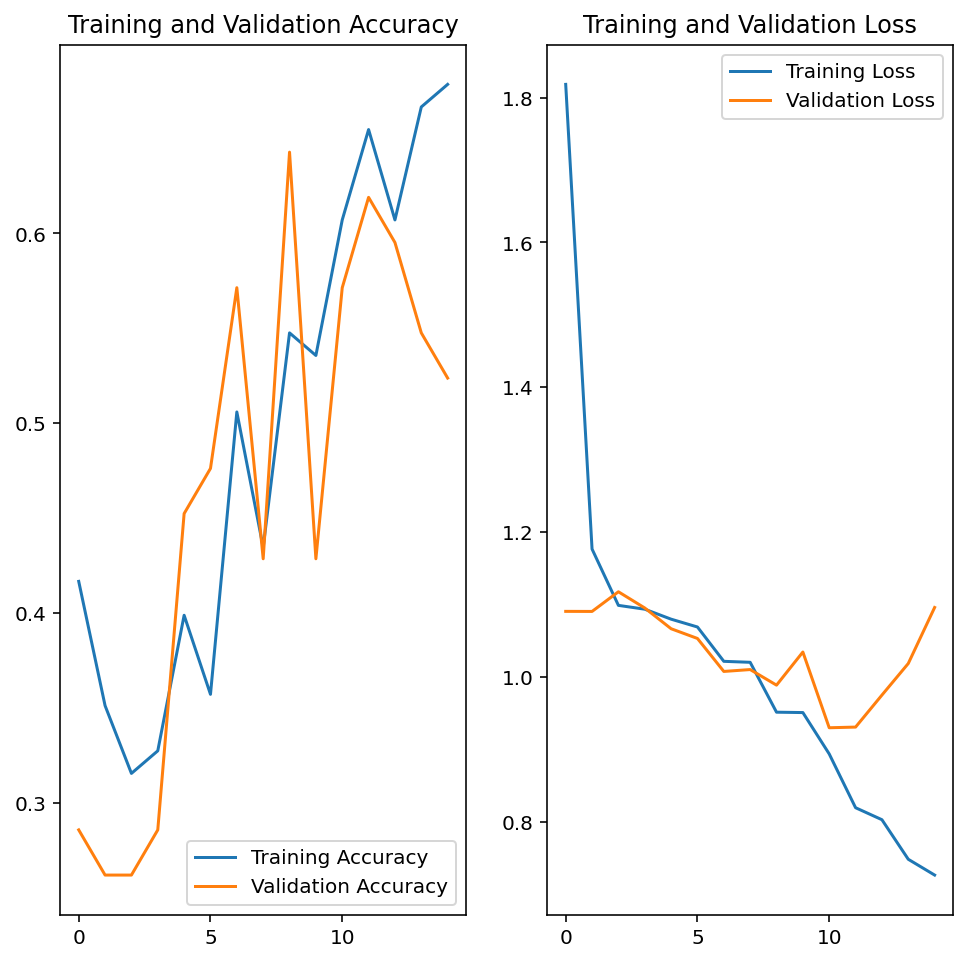

In [82]:
plot_accur_loss (history2, epochs)

In [21]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [44]:




src_path_train = r"C:\Users\march\000 Treball Ju`yter 000\Hackathons\Image_sports_classification\Imágenes-data-science-ii\train"
src_path_test = r"C:\Users\march\000 Treball Ju`yter 000\Hackathons\Image_sports_classification\Imágenes-data-science-ii\test"


batch_size = 60
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(180 ,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(180 ,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(180 ,180),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 169 images belonging to 3 classes.
Found 41 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


In [45]:
from keras import backend as K

def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,0:3]
    positive = y_pred[:,3:6]
    negative = y_pred[:,6:9]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [46]:
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
sgd=SGD(lr=0.01,momentum=0.9,decay=(0.01/25),nesterov=False)

def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(180, 180, 3)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(3, activation='sigmoid'))
    model.compile( loss='categorical_crossentropy',
                    metrics=['accuracy', custom_f1],
                    optimizer=sgd) #instead of 'adam' optimizer
    return model

In [48]:
model = prepare_model()
model.fit(train_generator,
            validation_data = train_generator,
            steps_per_epoch = train_generator.n//train_generator.batch_size,
            validation_steps = valid_generator.n//valid_generator.batch_size,
            epochs=15)

Epoch 1/15
2/2 [==============================] - 5s 2s/step - loss: 1.0994 - accuracy: 0.4220 - custom_f1: 0.4540
Epoch 2/15
2/2 [==============================] - 4s 2s/step - loss: 2.2767 - accuracy: 0.2294 - custom_f1: 0.2772
Epoch 3/15
2/2 [==============================] - 4s 2s/step - loss: 1.0977 - accuracy: 0.3945 - custom_f1: 0.3901
Epoch 4/15
2/2 [==============================] - 3s 1s/step - loss: 1.0978 - accuracy: 0.3670 - custom_f1: 0.3670
Epoch 5/15
2/2 [==============================] - 4s 2s/step - loss: 1.0967 - accuracy: 0.4000 - custom_f1: 0.4000
Epoch 6/15
2/2 [==============================] - 4s 2s/step - loss: 1.0980 - accuracy: 0.3486 - custom_f1: 0.3485
Epoch 7/15
2/2 [==============================] - 4s 2s/step - loss: 1.0944 - accuracy: 0.3917 - custom_f1: 0.3917
Epoch 8/15
2/2 [==============================] - 4s 2s/step - loss: 1.0948 - accuracy: 0.3917 - custom_f1: 0.3917
Epoch 9/15
2/2 [==============================] - 3s 1s/step - loss: 1.0981 - ac

In [ ]:
https://www.kaggle.com/code/gpiosenka/sports-using-csv-file-f1-score-96-7

Fem proves amb normalització per batch vs dropout:

Source: 
* https://github.com/skirenekim/Demystify_NeuralNets/blob/main/BatchNormalization_vs_Dropout/Batch_Normalization_vs_Dropout.ipynb
* https://medium.com/mlearning-ai/demystifying-batch-normalization-vs-drop-out-1c8310d9b516



In [6]:
# VGG2 with Batch Normalization with SGD
def CNN():
    input_layer = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(input_layer)
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    output_layer = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'CNN')
    model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.SGD(learning_rate=0.001),  metrics=['acc', 'AUC'])
    return model 

# more Batch Normalization layers with SGD
def CNN_more_BN():
    input_layer = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    output_layer = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'CNN')
    model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.SGD(learning_rate=0.001),  metrics=['acc', 'AUC'])
    return model 

# Batch Normalization with Adam 
def CNN_adam():
    input_layer = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.BatchNormalization()(x)
    output_layer = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'CNN')
    model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001),  metrics=['acc', 'AUC'])
    return model 


# VGG2 with Dropout
def CNN_Drop():
    input_layer = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(input_layer)
    x = keras.layers.Conv2D(32, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer = keras.initializers.HeUniform(seed=1))(x)
    x = keras.layers.Dropout(0.2)(x)
    output_layer = keras.layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'CNN')
    model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001),  metrics=['acc', 'AUC'])
    return model

In [7]:
model = CNN()
model_2 = CNN_more_BN()
model_3 = CNN_adam()
model_Drop = CNN_Drop()

In [13]:
my_callbacks = [
    EarlyStopping(patience=15),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience= 3, cooldown = 2, mode="min", min_lr=0.0001, verbose =1),
    #ModelCheckpoint(monitor="val_loss", save_best_only = True, filepath = model_path),
    TensorBoard(log_dir='C:/Users/march/000 Treball Ju`yter 000/Hackathons/Image_sports_classification/logs')
    ]

In [14]:

history_B1 = model.fit(X_train, y_train,  batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks = my_callbacks)

NameError: name 'X_train' is not defined